# Ecological Data Science for Sustainable Agriculture (Part II)

## Introduction

## Imports

In [1]:
# Vector processing
import geopandas as gpd
import shapely
import osgb

# Raster processing
import rasterio
import rasterio.warp
import rasterio.mask
import rasterio.plot
import rasterio.features
import rasterio.sample
from rasterio import windows
import pyproj
import xarray as xr
import rioxarray

# Calcs and modelling
import numpy as np
import pandas as pd

# Visualisation
import matplotlib as mpl
from matplotlib import pyplot as plt
import contextily as cx
import seaborn as sns

%matplotlib inline
mpl.rcParams['axes.formatter.limits'] = (0,0)
FIGSIZE = (10, 7)

# Practical
from glob import glob
import warnings
import os
from pystac_client import Client
import boto3
from dask.distributed import Client as DaskClient
from dask.distributed import print as distributed_print
import subprocess
import functools
import sys
sys.path.append('../../../../git_packages/PhenoloPy/scripts')
import phenolopy
from scipy.stats import pearsonr

warnings.filterwarnings('ignore')
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)

DATA_BASE_PATH = '../../../data/Agric_data/PoMS_Locations/' # all data under this path (global)
WORKING_CRS = 'EPSG:3035'


## Methods

### Biodiversity data

#### UK National Pollinator Monitoring Scheme

Here I'm using data from the UK Pollinator Monitoring Scheme (PoMS) [12], which provides pan-trap records relating to systematic 1 km square surveys at 95 locations across the UK. The squares are visited four times per year for data collection. The UK PoMS is the only scheme in the world to conduct systematic pollinator survey data on pollinator species abundance at a national scale [13].

Selecting one year to simplify the analysis (as was the case for ###CITE main reference) - 2019 has the most records so go with that.

In [15]:
insect_data = gpd.read_file("../../../data/Agric_data/Pollinator/data/ukpoms_1kmpantrapdata_2017-2020_insects.csv")

# X1km_square is the SW corner of the 1KM grid cell - so add 500m to centre the reference
insect_data['X1km_centre'] = insect_data['X1km_square'].str[:4].str.cat(insect_data['X1km_square'].str[4:], sep='5') + '5'
insect_data['geometry'] = insect_data['X1km_centre'].apply(osgb.gridder.parse_grid).apply(osgb.grid_to_ll).apply(lambda x: (x[1], x[0])).apply(shapely.geometry.Point)

# Convert to datetime
insect_data['date'] = pd.to_datetime(insect_data['date'])

# Count records to choose year
insect_data['count'] = insect_data['count'].astype(int)
# insect_data.groupby('year')['count'].sum()

# Select year
insect_data = insect_data[(insect_data['year'] == '2019')]


# Convert to an equal-area projection with units metres - so all the study areas have the same area
insect_data.set_crs('EPSG:4326', inplace=True).to_crs(WORKING_CRS, inplace=True)

# Insect tount cols
count_cols = ['wasps_solitary',
              'wasps_social',
              'wasps_parasitic',
              'sawflies',
              'flies',
              'moths',
              'butterflies',
              'beetles_pollen',
              'beetles_other',
              'insects_small',
              'insects_other',
              'spiders',
              'all_invertebrates_excluding_bees_hoverflies',
              'bees',
              'hoverflies',
              'all_invertebrates_including_bees_hoverflies']

# Convert types
insect_data = insect_data.astype({'location_code': int})

# Add a column for the number of pan trap stations at each location/date combination (used for correcting biodiversity metrics)
insect_data = insect_data.join(insect_data.groupby(['location_code', 'date'])['pan_trap_station'].nunique(), 
                 on=['location_code', 'date'], rsuffix='_total')

Calulcate biodiversity metrics for each location, pooling over sampling rounds [1]:
- Species richness: the number of unique species observed  (note there may be different sampling rates at different locations, check this)
- Species diversity (Shannon index): the number of unique species and their relative proportions
- Total abundance: sum of all individuals from all species

In [67]:
def test_group(group):
    unique_species = group['taxon_aggregated'].unique()
    s_tot = len(unique_species)
    n = group['pan_trap_station_total'].iloc[0]

    n_i = group.groupby('taxon_aggregated')['pan_trap_station'].nunique()

    display(n_i)
    
    display(group)
    raise ValueError

insect_data.groupby(['location_code', 'date']).apply(test_group)

taxon_aggregated
Andrena haemorrhoa    4
Andrena nigroaenea    1
Name: pan_trap_station, dtype: int64

,sample_id,country,location_code,location_name,X1km_square,date,year,pan_trap_station,occurrence_id,specimen_code,taxon_group,taxon_source,English_name,source_taxon_version_key,taxon_standardised,taxon_aggregated,count,sex,stage,comment,Order,Family,geometry,X1km_centre,pan_trap_station_total
8502,6810183,England,1,near Grangemill,SK2557,2019-05-14,2019,1,12634998,4453,insect - hymenopteran,Andrena haemorrhoa,Orange-tailed Mining Bee,NHMSYS0000875215,Andrena haemorrhoa,Andrena haemorrhoa,1,male,adult,,Hymenoptera,Andrenidae,POINT (3546685.709 3396138.293),SK255575,4
8503,6810183,England,1,near Grangemill,SK2557,2019-05-14,2019,1,12634999,4454,insect - hymenopteran,Andrena haemorrhoa,Orange-tailed Mining Bee,NHMSYS0000875215,Andrena haemorrhoa,Andrena haemorrhoa,1,male,adult,,Hymenoptera,Andrenidae,POINT (3546685.709 3396138.293),SK255575,4
8504,6810183,England,1,near Grangemill,SK2557,2019-05-14,2019,1,12635000,4455,insect - hymenopteran,Andrena haemorrhoa,Orange-tailed Mining Bee,NHMSYS0000875215,Andrena haemorrhoa,Andrena haemorrhoa,1,male,adult,,Hymenoptera,Andrenidae,POINT (3546685.709 3396138.293),SK255575,4
8505,6810183,England,1,near Grangemill,SK2557,2019-05-14,2019,1,12635001,4456,insect - hymenopteran,Andrena haemorrhoa,Orange-tailed Mining Bee,NHMSYS0000875215,Andrena haemorrhoa,Andrena haemorrhoa,1,female,adult,,Hymenoptera,Andrenidae,POINT (3546685.709 3396138.293),SK255575,4
8506,6810183,England,1,near Grangemill,SK2557,2019-05-14,2019,1,12635002,4457,insect - hymenopteran,Andrena haemorrhoa,Orange-tailed Mining Bee,NHMSYS0000875215,Andrena haemorrhoa,Andrena haemorrhoa,1,male,adult,,Hymenoptera,Andrenidae,POINT (3546685.709 3396138.293),SK255575,4
8507,6810184,England,1,near Grangemill,SK2557,2019-05-14,2019,2,12640413,4459,insect - hymenopteran,Andrena haemorrhoa,Orange-tailed Mining Bee,NHMSYS0000875215,Andrena haemorrhoa,Andrena haemorrhoa,1,not recorded,adult,,Hymenoptera,Andrenidae,POINT (3546685.709 3396138.293),SK255575,4
8508,6810184,England,1,near Grangemill,SK2557,2019-05-14,2019,2,12640414,4459,insect - hymenopteran,Andrena haemorrhoa,Orange-tailed Mining Bee,NHMSYS0000875215,Andrena haemorrhoa,Andrena haemorrhoa,1,male,adult,,Hymenoptera,Andrenidae,POINT (3546685.709 3396138.293),SK255575,4
8509,6810184,England,1,near Grangemill,SK2557,2019-05-14,2019,2,12640415,4460,insect - hymenopteran,Andrena haemorrhoa,Orange-tailed Mining Bee,NHMSYS0000875215,Andrena haemorrhoa,Andrena haemorrhoa,1,male,adult,,Hymenoptera,Andrenidae,POINT (3546685.709 3396138.293),SK255575,4
8510,6810184,England,1,near Grangemill,SK2557,2019-05-14,2019,2,12640416,4461,insect - hymenopteran,Andrena haemorrhoa,Orange-tailed Mining Bee,NHMSYS0000875215,Andrena haemorrhoa,Andrena haemorrhoa,1,male,adult,,Hymenoptera,Andrenidae,POINT (3546685.709 3396138.293),SK255575,4
8511,6810184,England,1,near Grangemill,SK2557,2019-05-14,2019,2,12640417,4462,insect - hymenopteran,Andrena haemorrhoa,Orange-tailed Mining Bee,NHMSYS0000875215,Andrena haemorrhoa,Andrena haemorrhoa,1,male,adult,,Hymenoptera,Andrenidae,POINT (3546685.709 3396138.293),SK255575,4


ValueError: 

In [63]:
def shannon(array):
    _, counts = np.unique(array, return_counts=True)
    counts = counts.astype(float) / float(len(array))
    shannon = -np.sum(np.multiply(counts, np.log(counts)))

    return shannon


# Calculate hoverfly and bee abundance using occurrence data, as well as other biodiversity indices
def bee_hoverfly_metrics(group):
    display(group.head())
    raise ValueError
    abundance = round(len(group) *  (1.0 / group['pan_trap_station_total'].iloc[0])) # prorate to abundance for a single trap
    
    species_richness = group['taxon_aggregated'].nunique() # Note the PoMS suggests use of taxon_aggregated for analysis, see documentation for explanation
    species_diversity = shannon(group['taxon_aggregated'].values) # Shannon
    
    return pd.Series({'abundance': abundance, 'species_richness': species_richness, 'shannon_diversity': species_diversity})


bee_hoverfly_biodiversity = insect_data.groupby(['location_code']).apply(bee_hoverfly_metrics)

,sample_id,country,location_code,location_name,X1km_square,date,year,pan_trap_station,occurrence_id,specimen_code,taxon_group,taxon_source,English_name,source_taxon_version_key,taxon_standardised,taxon_aggregated,count,sex,stage,comment,Order,Family,geometry,X1km_centre,pan_trap_station_total
5583,5964286,England,1,near Grangemill,SK2557,2019-06-20,2019,1,12476525,4200,insect - true fly (Diptera),Volucella bombylans,NA,NBNSYS0000007094,Volucella bombylans,Volucella bombylans,1,female,adult,,Diptera,Syrphidae,POINT (3546685.709 3396138.293),SK255575,4
5584,5964286,England,1,near Grangemill,SK2557,2019-06-20,2019,1,12640767,4199,insect - hymenopteran,Bombus lucorum sensu lato,White-tailed Bumblebee agg.,NHMSYS0020936546,Bombus lucorum/magnus/cryptarum,Bombus lucorum/terrestris/magnus/cryptarum,1,male,adult,,Hymenoptera,Apidae,POINT (3546685.709 3396138.293),SK255575,4
5585,5964347,England,1,near Grangemill,SK2557,2019-06-20,2019,2,12477173,4252,insect - true fly (Diptera),Cheilosia albitarsis sens.lat.,NA,NBNSYS0100002324,Cheilosia albitarsis/ranunculi,Cheilosia albitarsis/ranunculi,1,female,adult,,Diptera,Syrphidae,POINT (3546685.709 3396138.293),SK255575,4
5586,5964347,England,1,near Grangemill,SK2557,2019-06-20,2019,2,12640682,4253,insect - hymenopteran,Lasioglossum albipes,Bloomed Furrow Bee,NHMSYS0000876168,Lasioglossum albipes,Lasioglossum albipes,1,female,adult,,Hymenoptera,Halictidae,POINT (3546685.709 3396138.293),SK255575,4
5587,5964347,England,1,near Grangemill,SK2557,2019-06-20,2019,2,12640683,4254,insect - hymenopteran,Andrena haemorrhoa,Orange-tailed Mining Bee,NHMSYS0000875215,Andrena haemorrhoa,Andrena haemorrhoa,1,female,adult,,Hymenoptera,Andrenidae,POINT (3546685.709 3396138.293),SK255575,4


ValueError: 

##COMPARE against methodology with PMS data

For the purposes of estimating agricultural intensity in the vicinity of each sampling location, I consider a circle of radius 5 km centred on the sampling location. 

This represents a divergence from the methodology described in [1], where only the fields surveyed were selected for imagery analysis. As the S2 method is described for spring-sown cereals and there can be significant differences in vegetation indexes for different species CITE, and furthermore there is no guarantee that the PoMS survey locations are on spring-sown cereal fields, it is not possible to exactly replicate the methodology here.

Instead I look at the S2 imagery on grassland and cropland (specifically spring-sown cereals) in the vicinitiy of the PoMS sampling location to estimate the local land-use intensity proxy. To this end, I define a circle of radius two kilometres around the PoMS sampling location and calculation S2 indices on these areas.

Note that honey bees regularly travel this distance to forage, and have been witnessed more than 10 km from the hive [14], so defining a study zone around each sampling location in this way is not only practical within the constraints of the methodology here but also likely largely overlaps with areas frequented by the insects observed in the pan-traps.

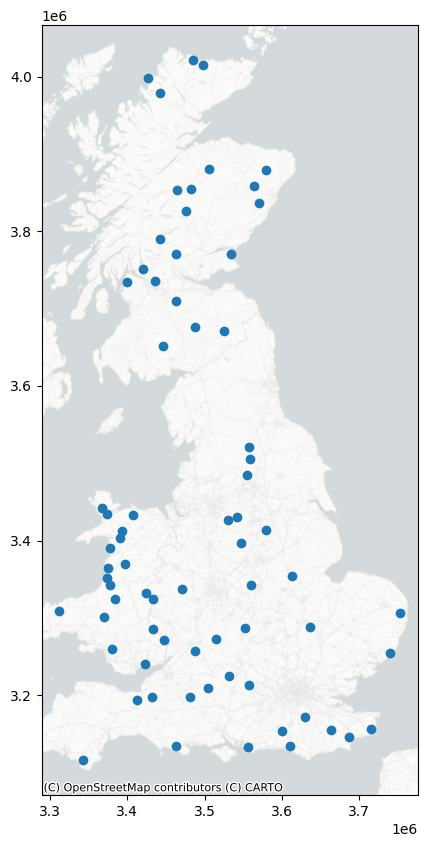

In [6]:
ax = sample_data.drop_duplicates('location_code').plot(figsize=(10, 10), edgecolor=None)
cx.add_basemap(ax, crs=sample_data.crs, source=cx.providers.CartoDB.PositronNoLabels)

### CROME data

The CROME data for each of these locations is downloaded outside of this script (HOW).

The locations are filtered for those with a spring cereal grown in the year corresponding to the PMS data, requiring a minimum of 3 CROME cells labeled spring cereal intersecting a 100 metre radius of the PMS sampling location.

In [7]:
SPRING_CEREAL_LUCODES = ['AC01', # barley
                         'AC19', # oats
                         'AC24', # rye
                         'AC30', # triticale
                         'AC32'] # wheat


In [11]:
######## PROBABLY GET RID OF THIS

sc_aoi_dirs = [] # correspond to PMS sample IDs
for i, location_path in enumerate(glob('../../../data/Agric_data/NPMS_Locations/*/CROME')):
    crome_data = gpd.read_file(location_path).to_crs(arable_samples_loc_yr_unique.crs)
    
    # filter for spring cereals
    crome_data = crome_data[crome_data['lucode'].isin(SPRING_CEREAL_LUCODES)]
    
    aoi_dir = location_path.split('/')[-2]
    id = int(aoi_dir.split('_')[1])
    
    sc_cells_in_radius = crome_data[crome_data.intersects(arable_samples_loc_yr_unique.loc[id, 'study_zone'])]
    
    if len(sc_cells_in_radius) >= 3:
        sc_aoi_dirs.append(aoi_dir)

Plot an example of a location where spring cereals were grown in the year, with the CROME data (SC only) and study zone overlaid:

<Axes: >

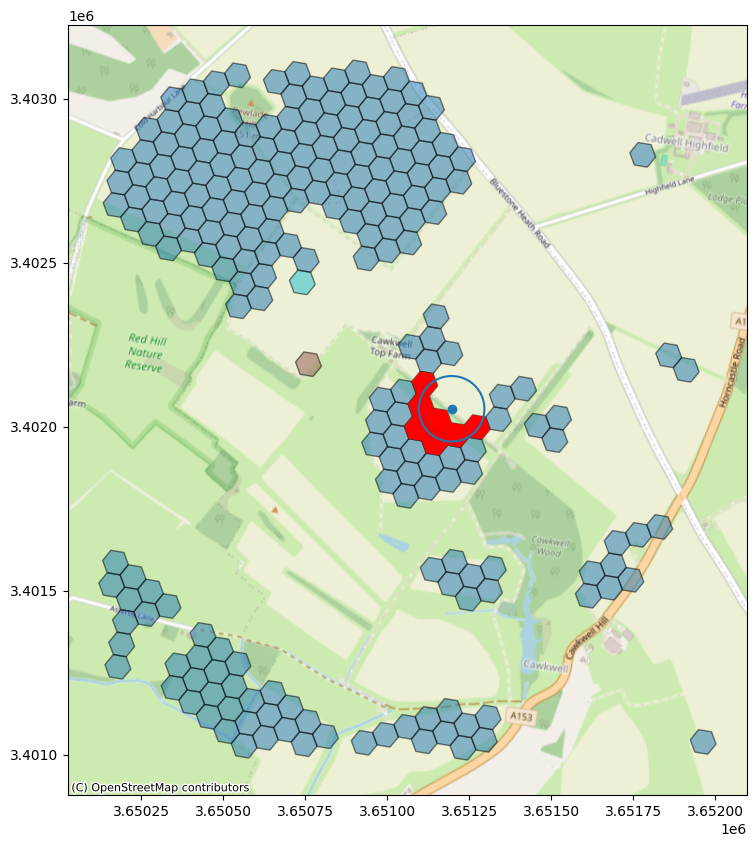

In [12]:
######## PROBABLY GET RID OF THIS


dir = sc_aoi_dirs[0]
id = int(dir.split('_')[1])

location_path = f'../../../data/Agric_data/NPMS_Locations/{dir}/CROME'

crome_data = gpd.read_file(location_path).to_crs(arable_samples_loc_yr_unique.crs)
    
# filter for spring cereals
crome_data = crome_data[crome_data['lucode'].isin(SPRING_CEREAL_LUCODES)]

sc_cells_in_radius = crome_data[crome_data.intersects(arable_samples_loc_yr_unique.loc[id, 'study_zone'])]

ax = crome_data.plot('lucode',figsize=(10, 10), alpha=0.5, edgecolor="k")
cx.add_basemap(ax, crs=arable_samples_loc_yr_unique.crs, source=cx.providers.OpenStreetMap.Mapnik, zoom=15)

arable_samples_loc_yr_unique.loc[[id]].plot(ax=ax)
arable_samples_loc_yr_unique.loc[[id]]['study_zone'].exterior.plot(ax=ax)
sc_cells_in_radius.plot(ax=ax, color='red')

### Download Sentinel-2 imagery

In [33]:
sample_data['study_zone'] = sample_data.geometry.buffer(2e3)
sample_data['study_zone_bbox'] = shapely.box(*np.split(sample_data['study_zone'].bounds.values, 4, axis=1)).flatten()

locations = sample_data.drop_duplicates('location_code').set_index('location_code')

In [34]:
def get_pystack_aws_sessions():
    '''Initiates a pystac client and rasterio AWS session to coordinate requests.'''
    
    # Instantiate a stac client to download the images
    client = Client.open("https://earth-search.aws.element84.com/v1")
    
    # Instantiate an AWS session to download S2 imagery
    aws_session = rasterio.session.AWSSession(boto3.Session(), requester_pays=True)

    return client, aws_session

client, aws_session = get_pystack_aws_sessions()

In [342]:
def read_S3(href, aoi_bbox_geodetic):
    '''Downloads the data and metadata corresponding to an acquisition, based on a 
    reference and spatial filter (defined as a shapely bbox in EPSG:4326).'''
    with rasterio.open(href) as src:
        # Transform window to src crs
        transform_geodetic_to_s2 = pyproj.Transformer.from_crs("EPSG:4326", src.crs, always_xy=True).transform
        src_bbox = shapely.ops.transform(transform_geodetic_to_s2, aoi_bbox_geodetic)
        window = rasterio.windows.from_bounds(*conform_bbox(src_bbox),
                                              transform=src.transform).round_lengths()
        data = src.read(window=window) 
        src_profile = src.profile
        
        src_profile.update({'width': window.width,
                            'height': window.height,
                            'transform': rasterio.windows.transform(window, src.transform)})

    return {'data': data, 'profile': src_profile}
    
def get_geodetic_bbox(bbox, bbox_crs):
    '''Transforms a bounding box (as a shapely box) in a given CRS to EPSG:4326'''
    # Get transformer for bbox
    transform_working_to_geodetic = pyproj.Transformer.from_crs(pyproj.CRS(bbox_crs), 
                                                                pyproj.CRS('EPSG:4326'), 
                                                                always_xy=True).transform
    # Get transformed bbox (in EPSG:4326)
    bbox_geodetic_coords = transform_working_to_geodetic(*bbox.exterior.xy)
    bbox_geodetic = shapely.geometry.Polygon(np.stack(bbox_geodetic_coords, axis=1))

    return bbox_geodetic

def conform_bbox(shapely_bbox):
    '''Returns coords as left, bottom, right, top from a shapely box.
    
    This is a utility function to go between shapely and (rasterio and pystac)'''
    shapely_bbox_coords = shapely_bbox.exterior.coords.xy
    rio_stac_bbox_coords = [min(shapely_bbox_coords[0]), # Align shapely and pystac conventions
                             min(shapely_bbox_coords[1]), 
                             max(shapely_bbox_coords[0]), 
                             max(shapely_bbox_coords[1])]
            
    return rio_stac_bbox_coords
    
def search_stac(client, aoi_bbox_geodetic=None, datetime=None, max_items=1000, query=None):
    '''searchs a stac collection with using client, filtering based on aoi_bbox_geodetic
    (a shapely box in EPSG:4326), and based on datetime. See pystac docs for client.search 
    API details.

    Note that pystac client expands datetimes, i.e. from the docs "2017 
    expands to 2017-01-01T00:00:00Z/2017-12-31T23:59:59Z".
    
    query examples:
      filter on processing baseline (see https://sentinels.copernicus.eu/web/sentinel/technical-guides/sentinel-2-msi/processing-baseline)
        query = {'s2:processing_baseline': {"neq": "05.00"}}

      filter on cloud cloverage
        query=['eo:cloud_cover<50']
    '''
    
    search = client.search(max_items=max_items, # speed up
                           collections=['sentinel-2-l2a'],
                           query=query,
                           bbox=conform_bbox(aoi_bbox_geodetic),
                           datetime=datetime)

    if search.matched() == max_items:
        distributed_print('Did not receive complete results. Consider increasing max_items kwarg ' + \
          f'(currently {max_items}).')

    return search


def item_covers_aoi(stac_item, aoi_geodetic):
    '''Returns true/false depending on whether the acquisition geometry fully covers the
    AOI.'''
    
    return shapely.geometry.shape(stac_item.geometry).contains(aoi_geodetic)

# Filter on clouds
def pass_clouds_snow(scl_data, max_cloud_perc=None):
    '''Returns true/false depending on whether the area proportion of the acquisition which
    is cloudy (according to the S2 cloud detection algorithm) is less than max_cloud_perc.
    
    Also includes snow/ice (SCL code 11).'''
    
    medium_cloud_prob = np.sum(scl_data == 8)
    high_cloud_prob = np.sum(scl_data == 9)
    snow_ice = np.sum(scl_data == 11)

    return (100 * ((medium_cloud_prob + high_cloud_prob + snow_ice) / np.size(scl_data))) < max_cloud_perc

def clean_dir(path):
    '''Clears up directories if download is re-run.'''
    files = os.listdir(path)
    if len(files) > 0:
        for file in files:
            distributed_print(f'### Cleaning (removing) {file}')
            os.remove(os.path.join(path, file))


def calculate_evi2(nir_data, red_data, profile):
    '''Returns the vegetation index EVI2 and corresponding raster profile.'''
    QUANT_VAL = 10000
    # Calculate evi2
    evi2 = 2.5 * ((nir_data / QUANT_VAL).astype(np.float32) - (red_data / QUANT_VAL).astype(np.float32)) / ((nir_data / QUANT_VAL).astype(np.float32) + 2.4*(red_data / QUANT_VAL).astype(np.float32) + 1)
    evi2_profile = {**profile, **{'nodata':np.nan, 'dtype': 'float32'}}

    return {'data': evi2, 'profile': evi2_profile}

def get_reprojected_profile(src_profile, target_crs, target_width=None, target_height=None, target_res=None):
    '''Calculates necessary changes to an arbritary source profile (a dictionary
    based on a rasterio read) to write to a target CRS or target width, height.'''
    
    transformer = rasterio.transform.AffineTransformer(src_profile['transform']) 
    left, top = transformer.xy(0,0, offset='ul')
    right, bottom = transformer.xy(src_profile['height'], src_profile['width'], offset='ul')
    
    # Get default transform
    transform, width, height = rasterio.warp.calculate_default_transform(src_profile['crs'], 
                                                                            target_crs, 
                                                                            src_profile['width'], 
                                                                            src_profile['height'], 
                                                                            left=left,
                                                                            bottom=bottom,
                                                                            right=right,
                                                                            top=top,
                                                                            dst_width=target_width,
                                                                            dst_height=target_height,
                                                                            dst_resolution=target_res)

    # Update profile with new crs, transform and dimensions
    transform, width, height = rasterio.warp.aligned_target(transform, width, height, target_res)
    
    new_profile = {k:v for k, v in src_profile.items()}
    new_profile.update({'crs': target_crs,
                        'transform': transform,
                        'width': width,
                        'height': height})

    return new_profile
    
def trim_raster(to_trim_path, geometry):
    '''Overwrites to_trim_path, trimming to (shapely) geometry defined in same CRS as raster.'''
    
    with rasterio.open(to_trim_path) as src:
        data, masked_transform = rasterio.mask.mask(src, [geometry], crop=True, all_touched=True)
        profile = src.profile
        
    profile.update({"height": data.shape[1],
                    "width": data.shape[2],
                    "transform": masked_transform})

    with rasterio.open(to_trim_path, "w", **profile) as dest:
        dest.write(data)
        
def reproject_clip_write(data, source_profile, target_profile, full_write_path, aoi_geometry):
    '''Reprojects S2 data to working CRS and writes to disk, clipping to AOI geometry.'''
    target_profile.update({'nodata': source_profile['nodata'], 'dtype': source_profile['dtype'], 'count': source_profile['count']})
    with rasterio.open(full_write_path, 'w', **target_profile) as dst:
        for i in range(1, target_profile['count'] + 1):
            rasterio.warp.reproject(source=data,
                                    destination=rasterio.band(dst, i),
                                    src_transform=source_profile['transform'],
                                    src_crs=source_profile['crs'],
                                    resampling=rasterio.warp.Resampling.nearest)

    trim_raster(full_write_path, aoi_geometry)
    


In [343]:
band_names = ['red', 'nir', 'visual']

MAX_ITEMS = 1000
max_cloud_perc = 10

def handle_download_errors(_download_items):
    def log_and_skip_errors(_dir_name):
        try:
            return _download_items(_dir_name)
        except Exception as e:
            distributed_print(f'Location: {_dir_name} :: ERROR (skipping) ' + str(e))
            return None

    return log_and_skip_errors
    
@handle_download_errors
def download_items(dir_name):
    '''Downloads all S2 data for a given PoMS location. dir_name contains the CROME data for the location (preprocessed).'''
    location_code = int(dir_name.split('_')[1])
    distributed_print(f'Location: {location_code} :: Starting location processing')
    data_path = os.path.join(DATA_BASE_PATH, dir_name)

    # # Skip this location if it was already processed
    if os.path.exists(os.path.join(data_path, 'metadata.csv')):
        distributed_print(f'Location: {location_code} :: Already processed, skipping')
        return None
        
    # Get search results
    true_aoi_bbox = locations.loc[location_code]['study_zone_bbox'] # in projected coords
    # buffer this by a pixel so that there are no missing corners in the data download (this can happen because of reprojections and finite resolution imagery)
    aoi_bbox = true_aoi_bbox.buffer(10, join_style=2)
    aoi_bbox_geodetic = get_geodetic_bbox(aoi_bbox, locations.crs) # in EPSG:4326
    search_results = search_stac(client, aoi_bbox_geodetic=aoi_bbox_geodetic, datetime='2019', 
                                 max_items=MAX_ITEMS, query={'s2:processing_baseline': {"neq": "05.00"}}) # Sentinel 2 reprocessing has not completed for 2019

    # Now iterate through dates with S2 acquisitions and download if they're good enough (intersect PoMS location fully and not too many clouds)
    for item in search_results.items():
        # Store date reference
        date_ref = item.datetime.strftime('%Y_%m_%d')
        base_write_path = os.path.join(data_path, date_ref)
        distributed_print(f'Location: {location_code}, Date: {date_ref} :: Starting acquisition processing') 
        
        # If there is already a folder here and it contains the right number of files, consider this date to be processed and skip
        if os.path.exists(base_write_path) and (len(os.listdir(base_write_path)) == (len(band_names) + 2)):
            distributed_print(f'Location: {location_code}, Date: {date_ref} :: Already have correct number of files, skipping')
            continue

        # Require full coverage of the AOI
        if not item_covers_aoi(item, aoi_bbox_geodetic):
            continue
            
        # Next a cloud check
        s2_thematic = read_S3(item.assets['scl'].href, aoi_bbox_geodetic)
        if not pass_clouds_snow(s2_thematic['data'], max_cloud_perc=max_cloud_perc):
            distributed_print(f'Location: {location_code}, Date: {date_ref} :: Too cloudy/snowy, skipping (more than {max_cloud_perc}% of image medium or high cloud probability / snowy)')
            continue

        # At this point we'll download the imagery, so create write directory if it does not already exist
        if not os.path.exists(base_write_path):
            os.mkdir(base_write_path)
        else:
            clean_dir(base_write_path)
            
        # Read data from S3 - already calculated scl so just add that to the dictionary instead of redownloading
        band_data = {band_name: read_S3(item.assets[band_name].href, aoi_bbox_geodetic) for band_name in band_names}
        band_data['scl'] = s2_thematic
        band_data['evi2'] = calculate_evi2(band_data['nir']['data'], # Vegetation index
                                           band_data['red']['data'],
                                           band_data['nir']['profile'].copy())

        # Define a target profile, which each raster will be aligned with
        target_height, target_width = (band_data['red']['profile'][i] for i in ['height', 'width'])
        target_res = (-band_data['red']['profile']['transform'][4], band_data['red']['profile']['transform'][0])
        target_profile = get_reprojected_profile(band_data['red']['profile'], WORKING_CRS, target_width=target_width, 
                                                 target_height=target_height, target_res=target_res)

        # Write results, reprojecting everything into WORKING_CRS and trimming to the AOI bbox
        for band_name, data_profile in band_data.items():
            full_write_path = os.path.join(base_write_path, band_name + '.tif')
            reproject_clip_write(data_profile['data'], data_profile['profile'], target_profile, full_write_path, true_aoi_bbox) # clip to true aoi bbox
            distributed_print(f'Location: {location_code}, Date: {date_ref} band: {band_name} :: Written to {full_write_path}')
            
    # Now create a file to hold any metadata we may want to add and also signals completion of this location's download            
    subprocess.run(['touch', os.path.join(data_path, 'metadata.csv')])
    
    return None

# with rasterio.Env(aws_session):
#     dask_client = DaskClient(threads_per_worker=4, n_workers=2)
#     futures = []
#     for dir in os.listdir(DATA_BASE_PATH):
#         future = dask_client.submit(download_items, dir)
#         futures.append(future)
    
#     dask_client.gather(futures)


In [383]:
##### TO DELETE THIS CELL

for location in os.listdir(DATA_BASE_PATH ):
    location_path = os.path.join(DATA_BASE_PATH, location)
    if not os.path.isdir(location_path):
        continue
        
    for date in os.listdir(location_path):
        date_path = os.path.join(location_path, date)
        
        if not '_' in date:
            continue

        red_path = os.path.join(date_path, 'red.tif')
        scl_path = os.path.join(date_path, 'scl.tif')
        


        with rasterio.open(red_path) as dst:
            with rasterio.open(scl_path) as src:
                tmp_profile = {k:v for k, v in src.profile.items()}
                tmp_profile.update({'crs': dst.crs,
                                    'transform': dst.transform,
                                    'width': dst.width,
                                    'height': dst.height})
                with rasterio.open(scl_path, 'w', **tmp_profile) as file:
                    rasterio.warp.reproject(src.read(1),
                                           destination=rasterio.band(file, 1),
                                           src_transform=src.transform,
                                           src_crs=src.crs,
                                           dst_transform=dst.transform,
                                           dst_crs=dst.crs,
                                           dst_resolution=dst.res,
                                           resampling=rasterio.warp.Resampling.nearest)

        

            

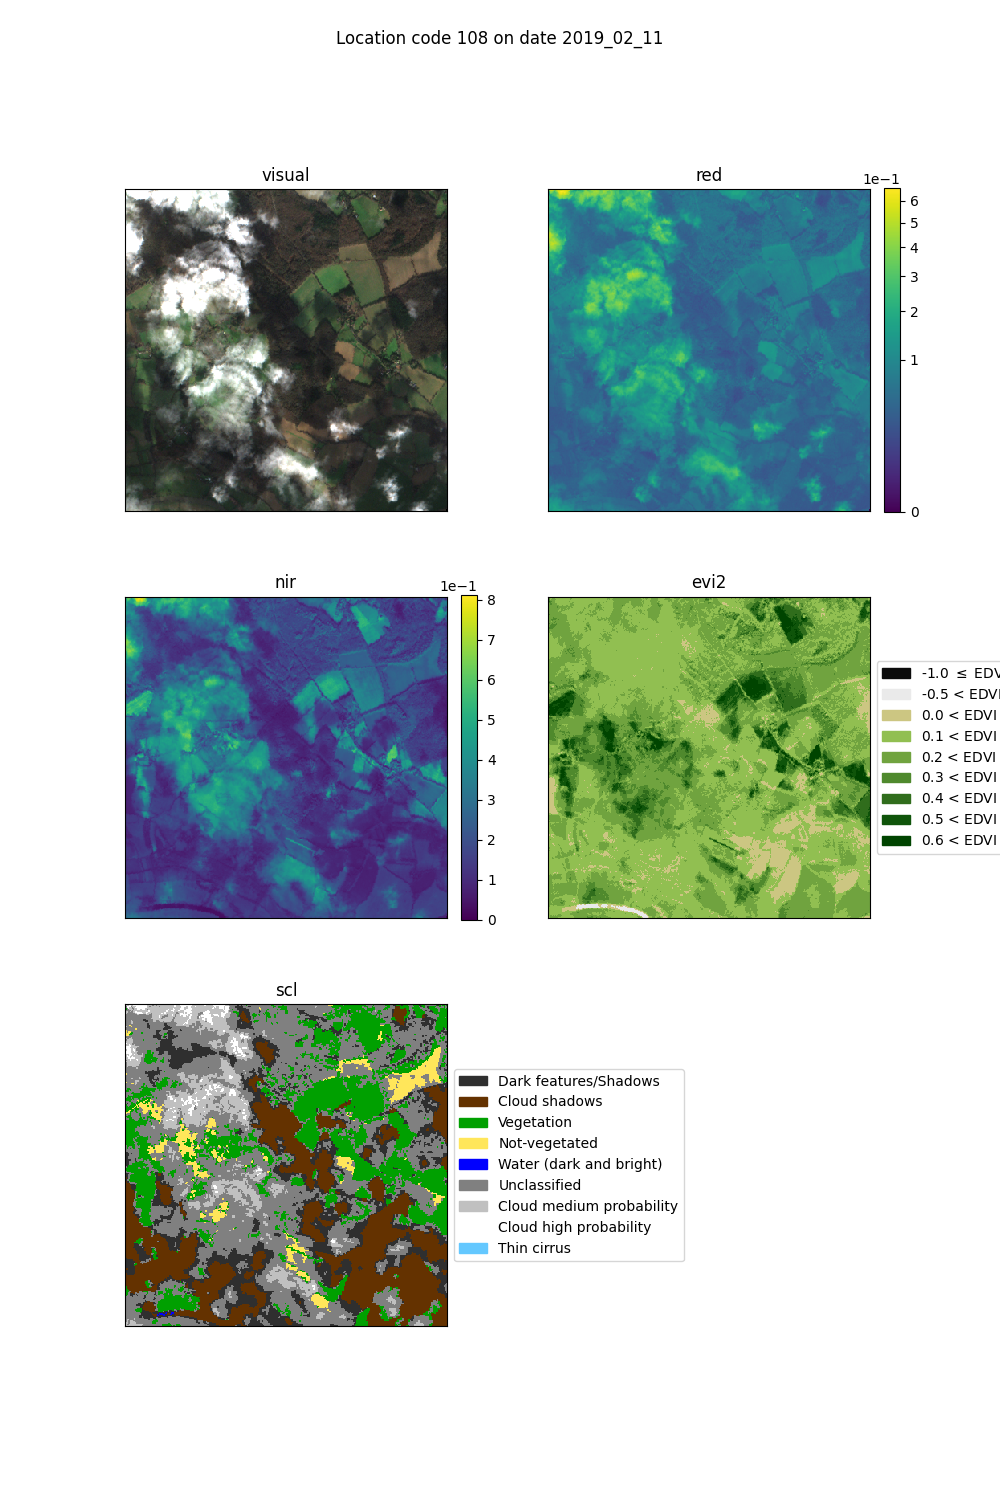

In [385]:
location_code = 108
date = '2019_02_11'


# Colormap as defined at https://custom-scripts.sentinel-hub.com/custom-scripts/sentinel-2/ndvi/
edvi_ranges = ['-1.0 $\leq$ EDVI $\leq$ -0.5',
               '-0.5 < EDVI $\leq$ 0.0',
               '0.0 < EDVI $\leq$ 0.1',
               '0.1 < EDVI $\leq$ 0.2',
               '0.2 < EDVI $\leq$ 0.3',
               '0.3 < EDVI $\leq$ 0.4',
               '0.4 < EDVI $\leq$ 0.5',
               '0.5 < EDVI $\leq$ 0.6',
               '0.6 < EDVI $\leq$ 1.0'
              ]

edvi_ranges_nums =  [-1.0, -0.5, 0.0,
                                    0.1,
                                    0.2,
                                    0.3,
                                    0.4,
                                    0.5,
                                    0.6,
                                    1.0]
edvi_colors = [[i/255 for i in [12, 12, 12]],
                        [i/255 for i in [234, 234, 234]],
                        [i/255 for i in [204, 198, 130]],
                        [i/255 for i in [145, 191, 81]],
                        [i/255 for i in [112, 163, 63]],
                        [i/255 for i in [79, 137, 45]],
                        [i/255 for i in [48, 109, 28]],
                        [i/255 for i in [15, 84, 10]],
                        [i/255 for i in [0, 68, 0]]]


# Color mapping for the scene classification
# Color map as described at https://custom-scripts.sentinel-hub.com/custom-scripts/sentinel-2/scene-classification/

classification_names = ['Dark features/Shadows',
                        'Cloud shadows',
                        'Vegetation',
                        'Not-vegetated',
                        'Water (dark and bright)',
                        'Unclassified',
                        'Cloud medium probability',
                        'Cloud high probability',
                        'Thin cirrus']

classification_colors = [[i/255 for i in [47, 47, 47]],
                        [i/255 for i in [100, 50, 0]],
                        [i/255 for i in [0, 160, 0]],
                        [i/255 for i in [255, 230, 90]],
                        [i/255 for i in [0, 0, 255]],
                        [i/255 for i in [128, 128, 128]],
                        [i/255 for i in [192, 192, 192]],
                        [i/255 for i in [255, 255, 255]],
                        [i/255 for i in [100, 200, 255]]]

scl_cmap = mpl.colors.LinearSegmentedColormap.from_list('SCL map', classification_colors, len(classification_colors))
scl_thematic_map = [mpl.patches.Patch(color=color, label=label) for color, label in zip(classification_colors, 
                                                                                        classification_names)]
scl_norm = mpl.colors.BoundaryNorm([i - 0.5 for i in range(2, 12)], scl_cmap.N)



edvi_cmap = mpl.colors.LinearSegmentedColormap.from_list('EDVI map', edvi_colors, len(edvi_colors))
edvi_thematic_map = [mpl.patches.Patch(color=color, label=label) for color, label in zip(edvi_colors, edvi_ranges)]
edvi_norm = mpl.colors.BoundaryNorm(edvi_ranges_nums, edvi_cmap.N)


fig, axs = plt.subplots( nrows=3, ncols=2, figsize=(10, 15))
axs = axs.ravel()

views = ['visual', 'red', 'nir', 'evi2', 'scl']
norms = [None, mpl.colors.PowerNorm(0.4), None, edvi_norm, scl_norm]
cmaps = [None, None, None, edvi_cmap, scl_cmap]
for i, view in enumerate(views):
    band_name = view
    with rasterio.open(os.path.join(DATA_BASE_PATH, f'location_{location_code}', date, view + '.tif')) as src:
        data_profile = {'data': src.read(), 'profile': src.profile}
    
    ax = axs[i]
    if view in ['red', 'nir']:
        plot_data = data_profile['data'] / 10000 # Quantification value
    else:
        plot_data = data_profile['data']
        
    im = ax.imshow(np.squeeze(np.moveaxis(plot_data, 0, -1)), 
                   norm=norms[i],
                   cmap=cmaps[i], 
                   # extent = [ref_bounds.left, ref_bounds.right, ref_bounds.bottom, ref_bounds.top],
                   interpolation='nearest', # Just for image / display resolution mismatches, does not alter underlying values
                  )
    
    ax.set_xticks([])
    ax.set_yticks([])
    # ax.text(0.5, -0.05, f'({band_name})', horizontalalignment='center', transform=ax.transAxes)
    ax.set_title(band_name, wrap=True)
    cbar = fig.colorbar(im, label=None, fraction=0.046, pad=0.04)
    if view == 'visual':
        cbar.ax.set_visible(False)
    elif view == 'scl':
        cbar.ax.set_visible(False)
        ax.legend(handles=scl_thematic_map, loc='center left', bbox_to_anchor=(1, 0.5))

    elif view == 'evi2':
        cbar.ax.set_visible(False)
        ax.legend(handles=edvi_thematic_map, loc='center left', bbox_to_anchor=(1, 0.5))
        
plt.suptitle(f'Location code {location_code} on date {date}')
axs[-1].set_axis_off()
# fig.tight_layout()
plt.show()

### Spring cereal productivity and phenology parameters from Sentinel-2 images


Working through an example on the acquisition shown above, create masks and carry out productivity and phenology on S2 imagery:

Define a mask to select only the study area from a raster:

In [464]:
aoi_dir = 'location_22' #os.listdir(DATA_BASE_PATH)[0]
date = [i for i in os.listdir(os.path.join(DATA_BASE_PATH, aoi_dir)) if '_' in i][0]


In [465]:
def rasterize_geoms(geoms, profile):
    '''Rasterizes geometries (geoms) according to a raster spec (profile).'''
    mask = rasterio.features.rasterize(geoms, 
                                        out_shape=(int(profile['height']), int(profile['width'])),
                                        fill=0,
                                        transform=profile['transform'],
                                        default_value=1, 
                                        dtype='uint8').astype(bool)
    return mask

def get_study_area_mask(aoi_dir):
    '''Returns a mask for the study area for a given location'''
    id = int(aoi_dir.split('_')[1])

    # Refer to arable_samples_loc_yr_unique as a global, which is the source of AOI specific metadata here
    study_zone_geom = locations.loc[id, 'study_zone']

    # Use the EVI2 profile for rasterize op
    evi2_path = glob(os.path.join(DATA_BASE_PATH, aoi_dir, '*', 'evi2.tif'))[0]
    evi2_profile = rasterio.open(evi2_path).profile

    return rasterize_geoms([study_zone_geom], evi2_profile)


Define a mask to remove bad pixels (according to Sentinel-2 scene classification):

In [466]:
def get_scl_good_mask(aoi_dir, date):
    '''Returns a mask that filters out "bad" pixels according to the S2 scene classification.'''
    scl_path = os.path.join(DATA_BASE_PATH, aoi_dir, date, 'scl.tif')

    scl_raw = rasterio.open(scl_path).read(1)
        
    scl_good_mask = ~np.isin(scl_raw, [0, # No data
                                       1, # Saturated/defective pixel
                                       6, # Water
                                       9, # Cloud high prob
                                       11]) # Snow or ice

    return scl_good_mask

Define a mask to identify pixels that are never vegetated: 

In [467]:
def get_scl_never_veg_mask(aoi_dir):
    '''Returns a mask that filters out pixels not labelled as vegetation according to S2 SCL for the entire period.'''
    
    def not_vegetated_mask(path):
        return rasterio.open(path).read(1) != 4

    base_path = os.path.join(DATA_BASE_PATH, aoi_dir, '*', 'scl.tif')
    scl_never_veg = ~functools.reduce(np.logical_and, [not_vegetated_mask(i) for i in glob(base_path)])

    return scl_never_veg



Now get masks based on crop designation. The method was originally applied to spring cereals, so return a spring cereal mask.

In [468]:
def get_crome_geoms(aoi_dir):
    '''Reads CROME data and converts to geometries on selected land-use codes.'''
    crome_path = os.path.join(DATA_BASE_PATH, aoi_dir, 'CROME')
    crome_data = gpd.read_file(crome_path)
    
    spring_cereal_geoms = crome_data[crome_data['lucode'].isin(SPRING_CEREAL_LUCODES)].dissolve().explode().to_crs(WORKING_CRS).geometry.to_numpy()

    return spring_cereal_geoms


def get_farmed_area(aoi_dir):
    '''Reads CROME data and calculates the land area used for spring cereal culitvation and also (all types of) agriculture for this tile.'''
    crome_path = os.path.join(DATA_BASE_PATH, aoi_dir, 'CROME')
    crome_data = gpd.read_file(crome_path)
    
    spring_cereal_area = crome_data[crome_data['lucode'].isin(SPRING_CEREAL_LUCODES)].dissolve().explode().to_crs(WORKING_CRS).geometry.area.sum()
    agric_area = crome_data[crome_data['lucode'].str.startswith(('AC', 'CA', 'LG', 'NU', 'TC', 'SR'))].dissolve().explode().to_crs(WORKING_CRS).geometry.area.sum()

    return spring_cereal_area, agric_area

def get_cereal_masks(aoi_dir):
    '''Gets cereal land-use masks based on CROME data.'''
    # For this location get CROME data (constant on a year)
    spring_cereal_geoms = get_crome_geoms(aoi_dir)
    
    # Convert shapes to rasters based on raster profile of an evi2.tif for this location (should all have the same profile)
    evi2_path = glob(os.path.join(DATA_BASE_PATH, aoi_dir, '*', 'evi2.tif'))[0]
    evi2_profile = rasterio.open(evi2_path).profile
    
    cereal_mask = rasterize_geoms(spring_cereal_geoms, evi2_profile)

    return cereal_mask



Apply masks to demo datapoint (single date in the timeseries) to show masking effect:

In [469]:
# Include the AOI mask and never_veg in the cereal mask for compactness
cereal_mask = get_cereal_masks(aoi_dir) & get_study_area_mask(aoi_dir) & get_scl_never_veg_mask(aoi_dir)

# Define relevant Xarray variables
evi2_paths = sorted(glob(os.path.join(DATA_BASE_PATH, aoi_dir, '*', 'evi2.tif')))
dates_xr = xr.Variable('time', pd.to_datetime([i.split('/')[-2] for i in evi2_paths], format='%Y_%m_%d'))
evi2_xr = xr.concat([rioxarray.open_rasterio(path) for path in evi2_paths], dim=dates_xr).squeeze()

# Create masks (date-specific) based on SCL good pixels
good_scl_masks_xr = xr.DataArray(np.stack([get_scl_good_mask(aoi_dir, date) for date in dates_xr.to_index().strftime('%Y_%m_%d')]),
                                 coords=evi2_xr.coords,
                                  dims=('time', 'y', 'x'))

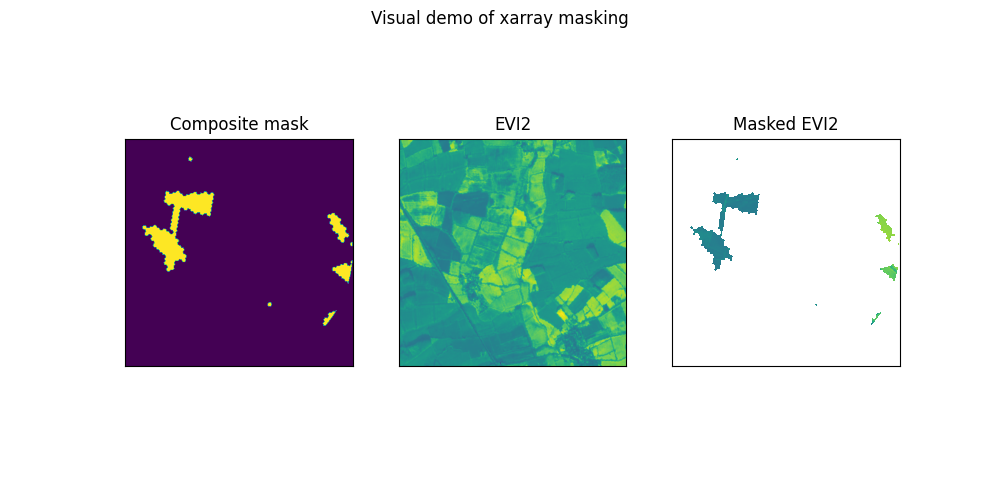

In [470]:
# Used chained where condition

fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(10,5))

ax = axs[0]
ax.imshow(xr.where(cereal_mask, xr.where(good_scl_masks_xr, 1, 0), 0).isel(time=0))
ax.set_title('Composite mask')

ax = axs[1]
ax.imshow(evi2_xr.isel(time=0))
ax.set_title('EVI2')

ax = axs[2]
ax.imshow(xr.where(cereal_mask, 
                      xr.where(good_scl_masks_xr, 
                               evi2_xr, 
                               np.nan), 
             np.nan).isel(time=0), interpolation=None, vmin=evi2_xr.isel(time=0).min(), vmax=evi2_xr.isel(time=0).max())
ax.set_title('Masked EVI2')

for ax in axs:
    ax.set_xticks([])
    ax.set_yticks([])
    
plt.suptitle("Visual demo of xarray masking")
plt.show()

### Phenology and productivity parameter calculations

Calculate imagery-derived phenology and productivity parameters for the demo datapoint.

As per https://github.com/lewistrotter/PhenoloPy/blob/main/Phenolopy.ipynb

Note that I've made a few minor fixes in my local version of the phenolopy module to make the functions play nicely with new xarray and numpy releases.

In [418]:
# Mask the EVI2 dataset
evi2_cereal_xr = xr.where(cereal_mask, 
                                  xr.where(good_scl_masks_xr, 
                                           evi2_xr, 
                                           np.nan), 
                          np.nan)

# Just do a bit of xarray preparation
evi2_cereal_xr = evi2_cereal_xr.drop_vars('band')
evi2_cereal_xr = evi2_cereal_xr.assign_coords({'spatial_ref': int(''.join([i for i in WORKING_CRS if i.isdigit()]))})

# Redefine as a dataset
evi2_cereal_xr = xr.Dataset({'veg_index': evi2_cereal_xr})
evi2_cereal_xr = evi2_cereal_xr.assign_attrs({'crs': WORKING_CRS, 'grid_mapping': 'spatial_ref'})

In [419]:
evi2_cereal_xr = phenolopy.group(evi2_cereal_xr)

Group dataset interval: month via reducer: median
> Selecting year: 2019 to re-label times after groupby.
> Warning: dataset contains nan values. You should interpolate nan values next.
> Group successful.



In [420]:
evi2_cereal_xr = phenolopy.remove_outliers(ds=evi2_cereal_xr, method='median', user_factor=2)

Outlier removal method: median with a user factor of: 2
> Generated roll window size less than 3, setting to default (3).
> Warning: dataset contains nan values. You may want to interpolate next.
> Outlier removal successful.



In [421]:
# set resample interval now, as a few functions require it
interval = '2W'

evi2_cereal_xr = phenolopy.correct_last_datetime(evi2_cereal_xr, interval)
evi2_cereal_xr = phenolopy.resample(evi2_cereal_xr, interval=interval, reducer='median')

Correcting last datetime value to ensure adequate resampling output.
> Changing day of last datetime value in dataset to the 31st.
> Corrected late datetime value successfully.
Resampling dataset interval: 2W via reducer: median
> Warning: dataset contains nan values. You should interpolate nan values next.
> Resample successful.



In [422]:
evi2_cereal_xr = phenolopy.interpolate(ds=evi2_cereal_xr, method='interpolate_na')
evi2_cereal_xr = phenolopy.remove_non_dominant_year(evi2_cereal_xr)


Interpolating dataset using method: interpolate_na.
> Warning: dataset still contains nan values. The first and/or last time slices may be empty.
> Interpolation successful.

Checking and removing non-dominant year often introduced following resampling.
> More than one year detected in dataset. Removal non-dominant years.
> Checked and removed non-dominant year (if needed) successfully.


In [423]:
evi2_cereal_xr = phenolopy.smooth(ds=evi2_cereal_xr, method='savitsky', window_length=3, polyorder=1)

Smoothing method: savitsky with window length: 3 and polyorder: 1.
> Warning: dataset contains nan values. You may want to interpolate next.
> Smoothing successful.



In [424]:
result = phenolopy.calc_phenometrics(evi2_cereal_xr['veg_index'], 
                                     peak_metric='pos', 
                                     base_metric='bse_fifth_per', 
                                     method='first_of_slope', 
                                     factor=0.5, 
                                     thresh_sides='two_sided', 
                                     abs_value=0)

Initialising calculation of phenometrics.

Beginning extraction of CRS metadata.
> Extracting CRS metadata.
> No CRS metadata found. Returning None.

Beginning calculation of phenometrics. This can take awhile - please wait.

Beginning calculation of peak of season (pos) values and times.
> Calculating peak of season (pos) values.
> Calculating peak of season (pos) times.
> Success!

Beginning calculation of fifth percentile veg index (bse_fifth_per) values.
> Calculating fifth percentile veg index (bse_fifth_per) values.
> Success!

Beginning calculation of amplitude of season (aos) values (times not possible).
> Calculating amplitude of season (aos) values.
> Success!

Beginning addition of CRS metadata.
> Adding CRS metadata.
> Could not add CRS metadata to data. Aborting.

Phenometrics calculated successfully!


Amplitude (aos) of the vegetation index id defined as the peak value (max observed in the season) minus the base value (fifth percentile of veg index) and was found to have the strongest correlation with farmer reported yields, alongside peak EVI2 ###CITE.

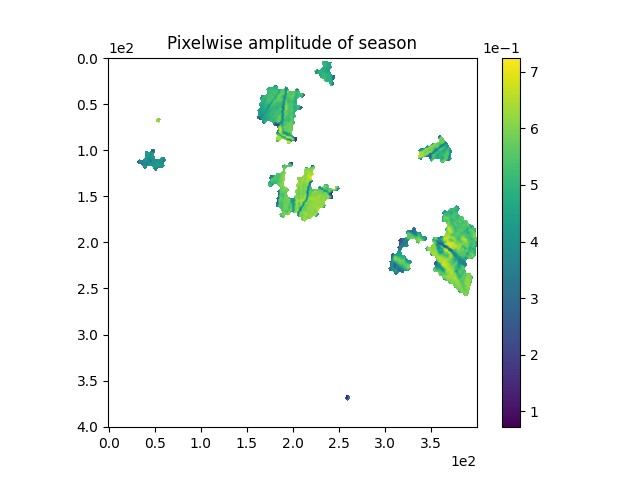

In [425]:
plt.figure()
plt.imshow(result.isel(phen_metric=2).to_numpy())
plt.colorbar()
# plt.title(result.isel(phen_metric=metric)['phen_metric'].to_numpy().__str__())
plt.title('Pixelwise amplitude of season')
plt.show()

Now plot the pixel-wise EVI2 time series, as well as the amplitude metric distribution for pixels labelled spring cereals according to CROME.

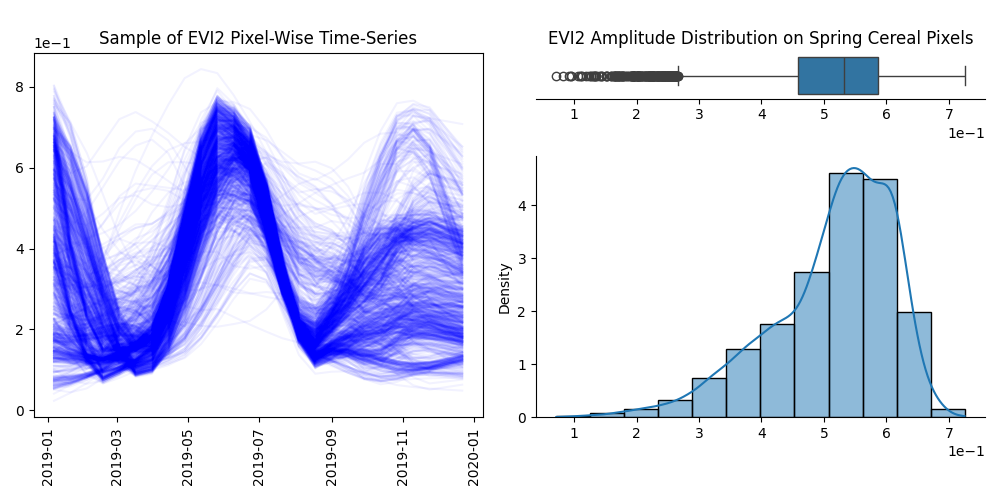

In [426]:
non_null_mask = ~evi2_cereal_xr.isnull().all('time')['veg_index'].to_numpy() # All nan slices
veg_index_timeseries = np.stack([evi2_cereal_xr.isel(time=i)['veg_index'].to_numpy()[non_null_mask] for i in range(evi2_cereal_xr.dims['time'])])
aos_vals = result.sel(phen_metric='aos_values').to_numpy()[non_null_mask]

# Create 2x2 sub plots
gs = mpl.gridspec.GridSpec(2, 2, height_ratios=(.15, .85))

plt.figure(figsize=(10, 5))

ax = plt.subplot(gs[:, 0]) 
for pixel_ref in range(0, veg_index_timeseries.shape[1], 10):
    ax.plot(evi2_cereal_xr.time, veg_index_timeseries[:, pixel_ref], color='b', alpha=0.05)
ax.set_title('Sample of EVI2 Pixel-Wise Time-Series')
ax.tick_params(axis='x', labelrotation=90)

_ax = plt.subplot(gs[0, 1]) # row 0, col 1
sns.boxplot(x=aos_vals, ax=_ax)
_ax.set(yticks=[])
sns.despine(ax=_ax, left=True)
_ax.set_title('EVI2 Amplitude Distribution on Spring Cereal Pixels')

ax = plt.subplot(gs[1, 1]) 
ax.sharex(_ax)
sns.histplot(x=aos_vals, bins=12, kde=True, stat='density', ax=ax)
sns.despine(ax=ax)


plt.tight_layout()
plt.show()



### Extend process to full imagery dataset

In [427]:
def get_aos(aoi_dir):
    '''Returns the median evi2 amplitude on spring cereal fields in AOI'''

    distributed_print(f'Beginning processing for {aoi_dir}')

    # Get static mask (independent of time) - sometimes there is no geometry to rasterize
    try:
        cereal_mask = get_cereal_masks(aoi_dir) & get_study_area_mask(aoi_dir) & get_scl_never_veg_mask(aoi_dir)
        spring_cereal_area, agric_area = get_farmed_area(aoi_dir)
        spr_cer_per = 100*spring_cereal_area/agric_area
        assert spr_cer_per > 5.0, "Spring cereal fields as percentage of farmed area less than threshold (5%), skipping"
    except Exception as e:
        distributed_print((aoi_dir, e))
        return aoi_dir, None
        
    

    # Define relevant Xarray variables
    evi2_paths = sorted(glob(os.path.join(DATA_BASE_PATH, aoi_dir, '*', 'evi2.tif')))
    dates_xr = xr.Variable('time', pd.to_datetime([i.split('/')[-2] for i in evi2_paths], format='%Y_%m_%d'))
    evi2_xr = xr.concat([rioxarray.open_rasterio(path) for path in evi2_paths], dim=dates_xr).squeeze()
    
    # Create masks (date-specific) based on SCL good pixels
    good_scl_masks_xr = xr.DataArray(np.stack([get_scl_good_mask(aoi_dir, date) for date in dates_xr.to_index().strftime('%Y_%m_%d')]),
                                     coords=evi2_xr.coords,
                                      dims=('time', 'y', 'x'))




    # Mask the EVI2 dataset
    evi2_cereal_xr = xr.where(cereal_mask, 
                                      xr.where(good_scl_masks_xr, 
                                               evi2_xr, 
                                               np.nan), 
                              np.nan)

    # Now for the phenology and productivity calculations
    # Just do a bit of xarray preparation
    evi2_cereal_xr = evi2_cereal_xr.drop_vars('band')
    evi2_cereal_xr = evi2_cereal_xr.assign_coords({'spatial_ref': int(''.join([i for i in WORKING_CRS if i.isdigit()]))})
    evi2_cereal_xr = xr.Dataset({'veg_index': evi2_cereal_xr})
    evi2_cereal_xr = evi2_cereal_xr.assign_attrs({'crs': WORKING_CRS, 'grid_mapping': 'spatial_ref'})
    evi2_cereal_xr = phenolopy.group(evi2_cereal_xr)
    evi2_cereal_xr = phenolopy.remove_outliers(ds=evi2_cereal_xr, method='median', user_factor=2, z_pval=0.05)
    interval = '2W'
    evi2_cereal_xr = phenolopy.correct_last_datetime(evi2_cereal_xr, interval)
    evi2_cereal_xr = phenolopy.resample(evi2_cereal_xr, interval=interval, reducer='median')
    evi2_cereal_xr = phenolopy.interpolate(ds=evi2_cereal_xr, method='interpolate_na')
    evi2_cereal_xr = phenolopy.remove_non_dominant_year(evi2_cereal_xr)
    evi2_cereal_xr = phenolopy.smooth(ds=evi2_cereal_xr, method='savitsky', window_length=3, polyorder=1)

    result = phenolopy.calc_phenometrics(evi2_cereal_xr['veg_index'], 
                                     peak_metric='pos', 
                                     base_metric='bse_fifth_per', 
                                     method='first_of_slope', 
                                     factor=0.5, 
                                     thresh_sides='two_sided', 
                                     abs_value=0)

    non_null_mask = ~evi2_cereal_xr.isnull().all('time')['veg_index'].to_numpy() # All nan slices
    veg_index_timeseries = np.stack([evi2_cereal_xr.isel(time=i)['veg_index'].to_numpy()[non_null_mask] for i in range(evi2_cereal_xr.dims['time'])])
    aos_vals = result.sel(phen_metric='aos_values').to_numpy()[non_null_mask]

    distributed_print(f'Done processing {aoi_dir}')

    return aoi_dir, np.median(aos_vals)



In [428]:

results = []
aoi_dirs = [i for i in os.listdir(DATA_BASE_PATH) if os.path.isdir(os.path.join(DATA_BASE_PATH, i)) and 'metadata.csv' in os.listdir(os.path.join(DATA_BASE_PATH, i))]
for aoi_dir in aoi_dirs:
    results.append(get_aos(aoi_dir))

results = pd.DataFrame(results, columns=['location', 'median_aos']).dropna()
results.to_csv(os.path.join(DATA_BASE_PATH, 'aos_results.csv'))

Beginning processing for location_128
('location_128', ValueError('No valid geometry objects found for rasterize'))
Beginning processing for location_32
Group dataset interval: month via reducer: median
> Selecting year: 2019 to re-label times after groupby.
> Warning: dataset contains nan values. You should interpolate nan values next.
> Group successful.

Outlier removal method: median with a user factor of: 2
> Generated roll window size less than 3, setting to default (3).
> Warning: dataset contains nan values. You may want to interpolate next.
> Outlier removal successful.

Correcting last datetime value to ensure adequate resampling output.
> Changing day of last datetime value in dataset to the 31st.
> Corrected late datetime value successfully.
Resampling dataset interval: 2W via reducer: median
> Warning: dataset contains nan values. You should interpolate nan values next.
> Resample successful.

Interpolating dataset using method: interpolate_na.
> Warning: dataset still con

## Results

In [444]:
aos_vals = pd.read_csv(os.path.join(DATA_BASE_PATH, 'aos_results.csv'), index_col=0)
aos_vals['location_code'] = aos_vals['location'].str.split('_').str[1].astype(int)
aos_vals.set_index('location_code', inplace=True)

In [456]:
bio_aos = pd.merge(aos_vals, bee_hoverfly_biodiversity, left_index=True, right_index=True, how='left')
bio_aos.sort_values('median_aos')

,location,median_aos,abundance,species_richness,shannon_diversity
location_code,,,,,
94,location_94,0.271053,45.0,24.0,2.976177
1,location_1,0.290002,159.0,35.0,2.695120
34,location_34,0.309578,93.0,27.0,2.732728
79,location_79,0.360096,21.0,9.0,1.838799
5,location_5,0.400586,67.0,25.0,2.725591
183,location_183,0.412538,84.0,30.0,2.910603
28,location_28,0.443202,47.0,18.0,2.299780
10,location_10,0.466537,26.0,15.0,2.459000
174,location_174,0.484767,34.0,17.0,2.715492


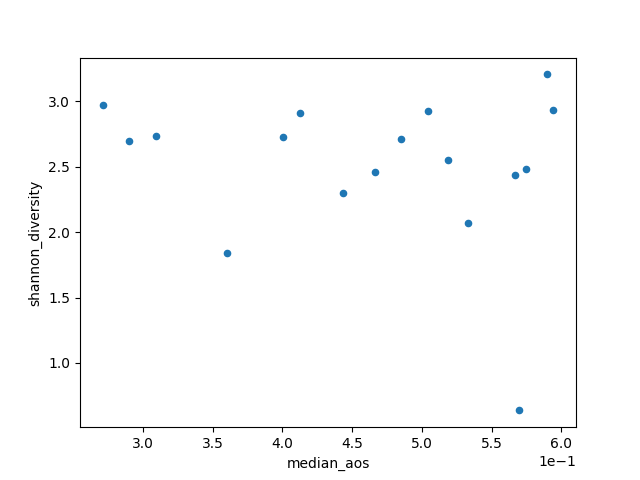

In [453]:
bio_aos.plot.scatter('median_aos', 'shannon_diversity')
plt.show()

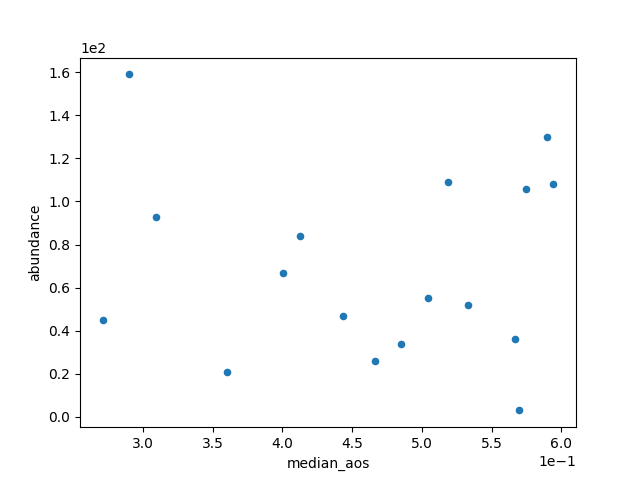

In [454]:
bio_aos.plot.scatter('median_aos', 'abundance')
plt.show()

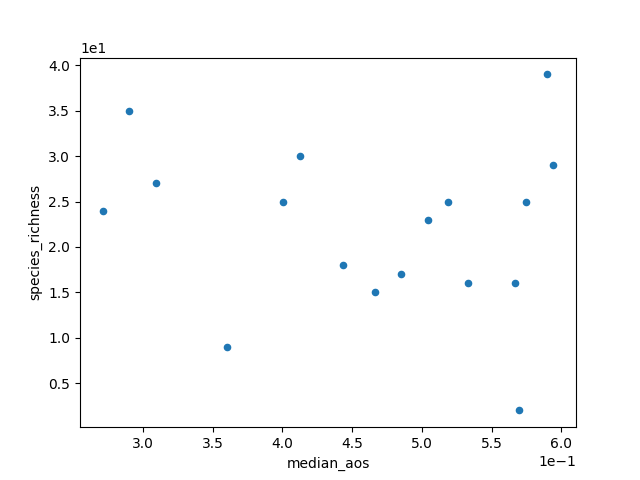

In [455]:
bio_aos.plot.scatter('median_aos', 'species_richness')
plt.show()

In [448]:
pearsonr(bio_aos['median_aos'], bio_aos['abundance'])

PearsonRResult(statistic=-0.05224663057278717, pvalue=0.8421493156067585)

In [449]:
pearsonr(bio_aos['median_aos'], bio_aos['species_richness'])


PearsonRResult(statistic=-0.14325802327965145, pvalue=0.5833352075844004)

In [450]:
pearsonr(bio_aos['median_aos'], bio_aos['shannon_diversity'])

PearsonRResult(statistic=-0.18678552938832535, pvalue=0.4728614046554873)

## References